Necessary imports

In [2]:
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score
import gpytorch

if os.environ['COMPUTERNAME'] == 'FYNN':            # name of surface PC
    sys.path.append(r'C:\Users\Surface\Masterarbeit')
elif os.environ['COMPUTERNAME'] == 'FYNNS-PC':  # desktop name
    sys.path.append(r'C:\Users\test\Masterarbeit')
    
else:
    raise ValueError("Unbekannter Computername: " + os.environ['COMPUTERNAME'])


Create an ExactGP on a representative subset (2500 samples) of the data

(2600, 37) (2600,)


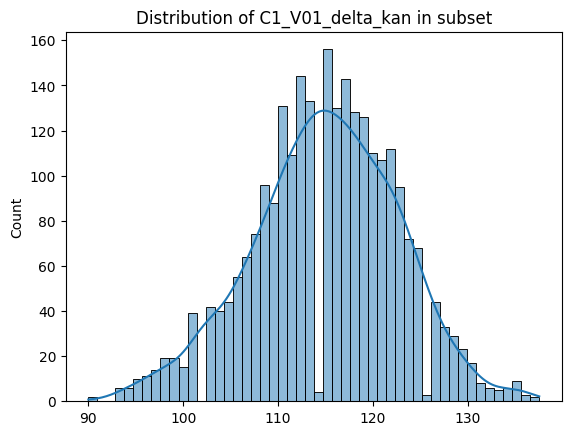

(1560, 37) (520, 37) (520, 37)
Feature names after preprocessing:
Index(['Ist_Blechhaltergewicht', 'Ist_Gegenhaltekraft_HL_1', 'T2', 'K1', 'T20',
       'K7', 'T23', 'K8', 'DS_10', 'GS_10', 'SD_10', 'LS_10', 'PP_10', 'TT_10',
       'TM5_10', 'RF_10', 'TD_10', 'is_weekend', 'dayofweek_sin',
       'dayofweek_cos', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos',
       'day_sin', 'day_cos', 'quarter_sin', 'quarter_cos', 'week_sin',
       'week_cos', 'Diff_Hubzahl', 'Diff_Ziehtiefe',
       'Diff_Ziehkissenverstellu', 'Diff_Stoesselverstellung-mm',
       'Diff_Gewichtsausgleich', 'BT_NR_freq', 'STP_NR_freq'],
      dtype='object')


In [2]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import data_prep

# check the computer name to determine the path to the data
if os.environ['COMPUTERNAME'] == 'FYNN':            # name of surface PC
    path = r"C:\Users\Surface\Masterarbeit\data\Produktionsdaten\WZ_2_Feature_Engineered_Fynn6.xlsx"
elif os.environ['COMPUTERNAME'] == 'FYNNS-PC':  # desktop name
    path = r"C:\Users\test\Masterarbeit\data\WZ_2_Feature_Engineered_Fynn6.xlsx"
    
df = pd.read_excel(path)

target = 'C1_V01_delta_kan'

x_data = df.drop(columns=[target])
y_data = df[target].to_numpy()

subset_x, x_rest, y_subset, y_rest = train_test_split(
    x_data, y_data, test_size=0.95, random_state=42)

print(subset_x.shape, y_subset.shape)

sns.histplot(y_subset, bins=50, kde =True)
plt.title('Distribution of C1_V01_delta_kan in subset')
plt.show()

X_temp, X_test, y_temp, y_test = train_test_split(subset_x, y_subset, test_size= 0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size= 0.25, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

# use custom function "cat_transform" to map the categorical features with their frequencies
X_train_prep, X_val_prep, X_test_prep = data_prep.cat_transform(X_train, X_val, X_test, ['BT_NR', 'STP_NR'])
# print(X_train_prep.columns)

    # pipeline for preprocessing the data
# Standard Scaler for distribution with 0 mean and 1 std., normal distributed data
data_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
    ])

# get the feature names after preprocessing for the feature importance
feature_names = X_train.columns

print("Feature names after preprocessing:")
print(feature_names)

# fit the pipeline to the data and transform it
X_train = data_pipeline.fit_transform(X_train)
X_val = data_pipeline.transform(X_val)
X_test = data_pipeline.transform(X_test)

In [ ]:
X_train_tensor = torch.from_numpy(X_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
X_test_tensor = torch.from_numpy(X_test).float() 
y_train_tensor = torch.from_numpy(y_train).float()
y_val_tensor = torch.from_numpy(y_val).float()
y_test_tensor = torch.from_numpy(y_test).float()
print(X_train_tensor.shape, X_val_tensor.shape, X_test_tensor.shape)
print(feature_names)

if torch.cuda.is_available():
    X_train_tensor = X_train_tensor.cuda()
    X_val_tensor = X_val_tensor.cuda()
    X_test_tensor = X_test_tensor.cuda()
    y_train_tensor = y_train_tensor.cuda()
    y_val_tensor = y_val_tensor.cuda()
    y_test_tensor = y_test_tensor.cuda()
    
print(type(X_train_tensor), X_train_tensor.shape)
#print(X_train.shape[1])

torch.Size([31206, 37]) torch.Size([10402, 37]) torch.Size([10403, 37])
Index(['Ist_Blechhaltergewicht', 'Ist_Gegenhaltekraft_HL_1', 'T2', 'K1', 'T20',
       'K7', 'T23', 'K8', 'DS_10', 'GS_10', 'SD_10', 'LS_10', 'PP_10', 'TT_10',
       'TM5_10', 'RF_10', 'TD_10', 'is_weekend', 'dayofweek_sin',
       'dayofweek_cos', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos',
       'day_sin', 'day_cos', 'quarter_sin', 'quarter_cos', 'week_sin',
       'week_cos', 'Diff_Hubzahl', 'Diff_Ziehtiefe',
       'Diff_Ziehkissenverstellu', 'Diff_Stoesselverstellung-mm',
       'Diff_Gewichtsausgleich', 'BT_NR_freq', 'STP_NR_freq'],
      dtype='object')
<class 'torch.Tensor'> torch.Size([31206, 37])
37


Train and fit Exact GPR

In [ ]:
import torch.distributions as dist

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, X_train, y_train, likelihood, kernel):
        super(ExactGPModel, self).__init__(X_train, y_train, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [ ]:
# initialize likelihood and model
exact_GP_likelihood = gpytorch.likelihoods.GaussianLikelihood()

rbf_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=X_train.shape[1]))
mattern_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(ard_num_dims=X_train.shape[1]))
polynomial_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PolynomialKernel(power = 2)) # ard_num_dims??
rational_quadratic_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel(ard_num_dims=X_train.shape[1]))

kernels =  [rbf_kernel, rational_quadratic_kernel]

for kernel in kernels:
    print(f'kernel : {kernel}\n\n')
    exact_GP_model = ExactGPModel(X_train_tensor, y_train_tensor, exact_GP_likelihood, kernel)

    y_mean = y_train_tensor.mean().item()
    exact_GP_model.mean_module.initialize(constant=y_mean)  # Initialize the mean to the mean of the training targets

    y_var = y_train_tensor.var().item()
    exact_GP_model.covar_module.outputscale = y_var  # Initialize the outputscale to the variance of the training targets

    training_iter = 300

    # Find optimal model hyperparameters
    if torch.cuda.is_available():
        exact_GP_model = exact_GP_model.cuda()
        exact_GP_likelihood = exact_GP_likelihood.cuda()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(exact_GP_model.parameters(), lr=0.05)  

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(exact_GP_likelihood, exact_GP_model)

    best_val_nll = np.inf
    patience = 20
    counter = 0

    for i in range(training_iter):
        exact_GP_model.train()
        exact_GP_likelihood.train()
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = exact_GP_model(X_train_tensor)
        
        # Calc loss and backprop gradients
        
        loss = -mll(output, y_train_tensor)
        loss.backward()   
        # print every ten iterations
        if (i + 1) % 10 == 0:
            print(f'Iter {i + 1}/{training_iter} - Loss: {loss.item():.3f}')
        optimizer.step()
        
            # Evaluate model and likelihood
        exact_GP_model.eval()
        exact_GP_likelihood.eval()
        
        with torch.no_grad():
            f_val_preds = exact_GP_model(X_val_tensor)
            val_preds = exact_GP_likelihood(f_val_preds)
            
            val_mean = val_preds.mean
            val_std= val_preds.stddev
            val_dist = dist.Normal(loc=val_mean, scale=val_std)
            val_nll = -val_preds.log_prob(y_val_tensor).mean().item()
            #print(val_nll)
           # print(type(y_val), type(val_mean))
            r2_score_val = r2_score(y_val, val_mean.cpu())
            
            print(f'Validation NLL: {val_nll} R²: {r2_score_val:.3f}')

            if val_nll < best_val_nll:
                best_val_nll = val_nll
                best_model_state = exact_GP_model.state_dict()
                best_likelihood_state = exact_GP_likelihood.state_dict()
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    print(f'Early stopping at iteration {i + 1} with best validation NLL: {best_val_nll:.3f} with R² Score {r2_score_val:.3f}')
                    exact_GP_model.load_state_dict(best_model_state)
                    exact_GP_likelihood.load_state_dict(best_likelihood_state)

                    torch.save({
                                'model_state_dict': exact_GP_model.state_dict(),
                                'likelihood_state_dict': exact_GP_likelihood.state_dict()
                            }, f'Modelsaves/exact_GP_{str(kernel).split('(')[2].split(':')[1] }.pth')
                    break
        
        

Get the final Model Parameters as starting point for Approximating GPR

In [18]:
# print the final model parameters and lengthscale and noise
print("Final model parameters:")
print(f"Mean: {exact_GP_model.mean_module.constant.item()}")
print(f"Outputscale: {exact_GP_model.covar_module.outputscale.item()}")
print(f"Lengthscale: {exact_GP_model.covar_module.base_kernel.lengthscale}")
print(f"Noise: {exact_GP_likelihood.noise.item()}")

Final model parameters:
Mean: 114.09266662597656
Outputscale: 57.804447174072266
Lengthscale: tensor([[0.6931, 1.2768, 1.2358, 1.1067, 1.2308, 1.2384, 1.1596, 1.0306, 1.2043,
         1.2182, 1.2572, 1.2285, 0.7150, 1.0114, 1.2296, 1.2199, 1.2597, 1.1920,
         0.8971, 1.2301, 0.4431, 0.3896, 1.1350, 1.1993, 1.1660, 1.2134, 0.7494,
         0.5630, 0.4222, 0.3636, 1.2500, 1.2188, 0.3174, 1.2156, 1.2657, 1.2576,
         0.7808]], device='cuda:0', grad_fn=<SoftplusBackward0>)
Noise: 5.422881603240967


Evaluate Exact GPR on reduced dataset

c:\Users\test\Masterarbeit\.venv\Lib\site-packages\gpytorch\models\exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


R² on Train Data: 0.987
R² on Validation Data: 0.735
R² on Test Data: 0.759
Number of true values within the confidence interval: 511 out of 520
Coverage: 98.27%


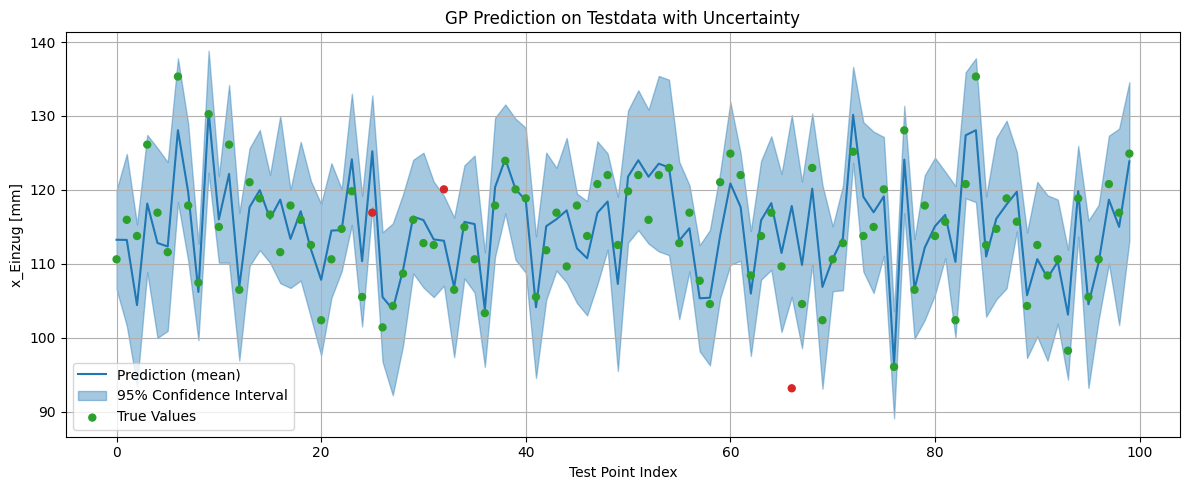

In [8]:
# Switch model and likelihood to evaluation mode
exact_GP_model.eval()
exact_GP_likelihood.eval()

# Predictive distribution for train data (no gradients required)
with torch.no_grad():
    f_preds = exact_GP_model(X_train_tensor)            # Latent function predictions
    y_preds = exact_GP_likelihood(f_preds)        # Observed predictions with noise

# Extract mean and standard deviation from predictions

train_mean = y_preds.mean.cpu().numpy()

# Calculate R² for the train data
r2_test = r2_score(y_train, train_mean)
print(f"R² on Train Data: {r2_test:.3f}")

with torch.no_grad():
    f_preds_val = exact_GP_model(X_val_tensor)            # Latent function predictions
    y_preds_val = exact_GP_likelihood(f_preds_val)        # Observed predictions with noise
    
val_eman = y_preds_val.mean.cpu().numpy()

r2_val = r2_score(y_val, val_eman)
print(f"R² on Validation Data: {r2_val:.3f}")

# Predictive distribution for test data (no gradients required)
with torch.no_grad():
    f_preds = exact_GP_model(X_test_tensor)            # Latent function predictions
    y_preds = exact_GP_likelihood(f_preds)        # Observed predictions with noise

# Extract mean and standard deviation from predictions
test_mean = y_preds.mean.cpu().numpy()
test_stddev = y_preds.stddev.cpu().numpy()

# Calculate R² for the test data
r2_test = r2_score(y_test, test_mean)
print(f"R² on Test Data: {r2_test:.3f}")

num_points = 100
np.random.seed(42)

random_indices = np.random.choice(len(X_test), num_points, replace=False)
random_indices.sort()

# Define the confidence interval bounds (95% CI ≈ mean ± 2*std)
gp_lower = test_mean - 2*test_stddev
gp_upper = test_mean + 2*test_stddev

# Check whether each true value lies within the 95% confidence interval
# If yes, the point will be green; if not, red
in_interval = (y_test >= gp_lower) & (y_test <= gp_upper)

CI_counter = 0
# Print whether each true value is within the confidence interval
for i in in_interval:
    if i:
        CI_counter += 1

print(f"Number of true values within the confidence interval: {CI_counter} out of {len(in_interval)}")

# Calculate coverage (percentage of true values within the CI)
coverage = np.mean(in_interval) * 100  # in percentage

# Print the coverage value
print(f"Coverage: {coverage:.2f}%")

# Check whether each true value from random indices lies within the 95% confidence interval
# If yes, the point will be green; if not, red
in_interval_rand_indi = (y_test[random_indices] >= gp_lower[random_indices]) & (y_test[random_indices] <= gp_upper[random_indices])
colors = ['tab:green' if inside else 'tab:red' for inside in in_interval_rand_indi]

# Plotting the prediction with uncertainty and true values
plt.figure(figsize=(12, 5))
x_axis = np.arange(num_points)

# Plot predicted mean
plt.plot(x_axis, test_mean[random_indices], label="Prediction (mean)", color='tab:blue')

# Shade the 95% confidence interval (±2 standard deviations)
plt.fill_between(x_axis, gp_lower[random_indices], gp_upper[random_indices],
                 alpha=0.4, color='tab:blue', label='95% Confidence Interval')

# Plot true target values as orange dots
plt.scatter(x_axis, y_test[random_indices], label="True Values", c=colors, s=25, zorder=3)

# Add plot labels and formatting
plt.title("GP Prediction on Testdata with Uncertainty")
plt.xlabel("Test Point Index")
plt.ylabel("x_Einzug [mm]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
# Speichern
torch.save({
    'model_state_dict': exact_GP_model.state_dict(),
    'likelihood_state_dict': exact_GP_likelihood.state_dict()
}, "Modelsaves/exact_GP_RBF.pth")

In [26]:
checkpoint = torch.load("Modelsaves/exact_GP_RBF.pth")
#C:\Users\test\Masterarbeit\models\Modelsaves\exact_GP_ RBFKernel.pth

exact_GP_model = ExactGPModel(X_train_tensor, y_train_tensor, gpytorch.likelihoods.GaussianLikelihood(), rbf_kernel)
exact_GP_likelihood = gpytorch.likelihoods.GaussianLikelihood()

exact_GP_model.load_state_dict(checkpoint['model_state_dict'])
exact_GP_likelihood.load_state_dict(checkpoint['likelihood_state_dict'])

C:\Users\test\AppData\Local\Temp\ipykernel_18136\4030714420.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("Modelsaves/exact_GP_RBF.pth")


<All keys matched successfully>

In [27]:
lengthscale = exact_GP_model.covar_module.base_kernel.lengthscale.detach().cpu()
outputscale = exact_GP_model.covar_module.outputscale.detach().cpu()
noise = exact_GP_likelihood.noise.detach().cpu()

print(f"Lengthscale: {lengthscale}")
print(f"Outputscale: {outputscale}")
print(f"Noise: {noise}")

Lengthscale: tensor([[0.6931, 1.2768, 1.2358, 1.1067, 1.2308, 1.2384, 1.1596, 1.0306, 1.2043,
         1.2182, 1.2572, 1.2285, 0.7150, 1.0114, 1.2296, 1.2199, 1.2597, 1.1920,
         0.8971, 1.2301, 0.4431, 0.3896, 1.1350, 1.1993, 1.1660, 1.2134, 0.7494,
         0.5630, 0.4222, 0.3636, 1.2500, 1.2188, 0.3174, 1.2156, 1.2657, 1.2576,
         0.7808]])
Outputscale: 57.804447174072266
Noise: tensor([5.4229])


Transformation Pipeline for Approximating GPR

In [3]:
import data_prep

X_train, X_val, X_test, y_train, y_val, y_test, feature_names = data_prep.load_tranform_and_split_data('C1_V01_delta_kan', split_ratio=(0.6, 0.2, 0.2))

# convert the data to PyTorch tensors
# and add an extra dimension for the target variable
X_train_tensor = torch.from_numpy(X_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
X_test_tensor = torch.from_numpy(X_test).float() 
y_train_tensor = torch.from_numpy(y_train).float() # Add extra dimension for compatibility
y_val_tensor = torch.from_numpy(y_val).float()
y_test_tensor = torch.from_numpy(y_test).float()
print(X_train_tensor.shape, X_val_tensor.shape, X_test_tensor.shape)
print(feature_names)

if torch.cuda.is_available():
    X_train_tensor = X_train_tensor.cuda()
    X_val_tensor = X_val_tensor.cuda()
    X_test_tensor = X_test_tensor.cuda()
    y_train_tensor = y_train_tensor.cuda()
    y_val_tensor = y_val_tensor.cuda()
    y_test_tensor = y_test_tensor.cuda()

torch.Size([31206, 37]) torch.Size([10402, 37]) torch.Size([10403, 37])
Index(['Ist_Blechhaltergewicht', 'Ist_Gegenhaltekraft_HL_1', 'T2', 'K1', 'T20',
       'K7', 'T23', 'K8', 'DS_10', 'GS_10', 'SD_10', 'LS_10', 'PP_10', 'TT_10',
       'TM5_10', 'RF_10', 'TD_10', 'is_weekend', 'dayofweek_sin',
       'dayofweek_cos', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos',
       'day_sin', 'day_cos', 'quarter_sin', 'quarter_cos', 'week_sin',
       'week_cos', 'Diff_Hubzahl', 'Diff_Ziehtiefe',
       'Diff_Ziehkissenverstellu', 'Diff_Stoesselverstellung-mm',
       'Diff_Gewichtsausgleich', 'BT_NR_freq', 'STP_NR_freq'],
      dtype='object')


Exact GP with KeOps for faster Matrix Multiplication
not possible because of memory capacity

In [3]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, X_train, y_train, likelihood, kernel):
        super(ExactGPModel, self).__init__(X_train, y_train, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [4]:
likelihood = gpytorch.likelihoods.GaussianLikelihood().cuda()
matern_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.keops.MaternKernel(nu=2.5, ard_num_dims=X_train.shape[1]))
model = ExactGPModel(X_train_tensor, y_train_tensor, likelihood, matern_kernel).cuda()

model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

import time
training_iter = 50

for i in range(training_iter):
    start_time = time.time()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = -mll(output, y_train_tensor)
    loss.backward()

    print(f'Iter {i + 1}/{training_iter} - Loss: {loss.item():.3f} lengthscale: {model.covar_module.base_kernel.lengthscale.item()} noise: {model.likelihood.noise.item()}')
    optimizer.step()
    print(time.time() - start_time)

OutOfMemoryError: CUDA out of memory. Tried to allocate 134.23 GiB. GPU 0 has a total capacity of 2.00 GiB of which 1.49 GiB is free. Of the allocated memory 43.70 MiB is allocated by PyTorch, and 18.30 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

GPR with Structured Kernel Interpolation (SKI) not possible because of memory capacity

In [ ]:
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, X_train, y_train, likelihood):
        super(GPRegressionModel, self).__init__(X_train, y_train, likelihood)

        grid_size = gpytorch.utils.grid.choose_grid_size(X_train.shape[0], 1.0)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=X_train.shape[1]),
                grid_size=grid_size, num_dims=1)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [6]:
likelihood = gpytorch.likelihoods.GaussianLikelihood().cuda()
model = ExactGPModel(X_train_tensor, y_train_tensor, likelihood, matern_kernel).cuda()

model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

import time
training_iter = 50

for i in range(training_iter):
    start_time = time.time()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = -mll(output, y_train_tensor)
    loss.backward()

    print(f'Iter {i + 1}/{training_iter} - Loss: {loss.item():.3f} lengthscale: {model.covar_module.base_kernel.lengthscale.item()} noise: {model.likelihood.noise.item()}')
    optimizer.step()
    print(time.time() - start_time)

OutOfMemoryError: CUDA out of memory. Tried to allocate 134.23 GiB. GPU 0 has a total capacity of 2.00 GiB of which 1.47 GiB is free. Of the allocated memory 71.53 MiB is allocated by PyTorch, and 10.47 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Stochastic Variational GP Regression Implementation

Natural Gradient Descent with Variational Models for better and faster convergence

In [4]:
import gpytorch
from gpytorch.models import ApproximateGP
from torch.distributions import Normal

#create a TensorDataset and DataLoader for the training data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

class GPModel(ApproximateGP):
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.NaturalVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module  = kernel
        
        
        self.mean_module.initialize(constant=y_train_tensor.mean().item())  # Initialize the mean to the mean of the training targets
        #self.covar_module.base_kernel.lengthscale = 1
        # self.covar_module.outputscale = outputscale  # Initialize the outputscale to the variance of the training targets
        
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [ ]:
from sklearn.cluster import KMeans

rbf_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=X_train.shape[1]))
mattern_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(ard_num_dims=X_train.shape[1]))
#polynomial_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PolynomialKernel(power = 4)) # immer fehler bei Berechnung not positive definite after repeatedly adding jitter up to 1.0e-04.
rational_quadratic_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel(ard_num_dims=X_train.shape[1], 
                                                                                   alpha_constraint=gpytorch.constraints.Interval(0.1, 10.0)))
rq_kernel = gpytorch.kernels.RQKernel(
    ard_num_dims=X_train.shape[1],
    alpha_constraint=gpytorch.constraints.Interval(0.1, 10.0)
)
linear_kernel = gpytorch.kernels.LinearKernel()

kernel_addition = gpytorch.kernels.ScaleKernel(rq_kernel + linear_kernel)
kernel_addition_1 = gpytorch.kernels.ScaleKernel(rbf_kernel + linear_kernel)
kernel_addition_2 = gpytorch.kernels.ScaleKernel(mattern_kernel + linear_kernel)

kernel_product = gpytorch.kernels.ScaleKernel(rq_kernel * linear_kernel)
kernel_product_1 = gpytorch.kernels.ScaleKernel(rbf_kernel * linear_kernel)
kernel_product_2 = gpytorch.kernels.ScaleKernel(mattern_kernel * linear_kernel)

kernel_additive_structure = gpytorch.kernels.AdditiveStructureKernel(
    gpytorch.kernels.RQKernel(
        alpha_constraint=gpytorch.constraints.Interval(0.1, 10.0)
    ),
    num_dims=X_train.shape[1]
)
kernels = [
    rbf_kernel,
    mattern_kernel,
    rational_quadratic_kernel,
    kernel_addition,
    kernel_addition_1,
    kernel_addition_2,
    #kernel_product,
    #kernel_product_1,
    #kernel_product_2,
    #kernel_additive_structure,
    
    
]

for kernel in kernels:
    kernel_name = type(kernel.base_kernel).__name__
    print(kernel_name)
    # Define the inducing points
    # Randomly select 1500 inducing points from the training data
    num_inducing_points = 1000
    
    kmeans = KMeans(n_clusters=num_inducing_points, random_state=42).fit(X_train)
    inducing_points = torch.from_numpy(kmeans.cluster_centers_).float()

    # print(inducing_points.shape)
    # print(inducing_points)

    model = GPModel(inducing_points = inducing_points, kernel=kernel)
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    #likelihood.noise = noise

    print(model)
    print(model.mean_module.constant.item())
    print(model.covar_module.base_kernel.lengthscale)
    if torch.cuda.is_available():
        model = model.cuda()
        likelihood = likelihood.cuda()

    num_epochs = 50

    model.train()
    likelihood.train()

    variational_ngd_optimizer = gpytorch.optim.NGD(model.variational_parameters(), num_data= y_train_tensor.size(0), lr=0.1)

    hyperparameter_optimizer = torch.optim.Adam([
        {'params': model.hyperparameters()},
        {'params': likelihood.parameters()},
    ], lr=0.02)

    # VariationalELBO is used for training
    mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=len(train_loader.dataset))

    best_val_nll = np.inf
    patience = 10
    epochs_no_improve = 0
    decimal_places = 3
    tolerance = 10 ** (-decimal_places)

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        model.train()
        likelihood.train()
        for x_batch, y_batch in train_loader:
            # Zero gradients from previous iteration        
            variational_ngd_optimizer.zero_grad()
            hyperparameter_optimizer.zero_grad()
            output = model(x_batch)
            loss = -mll(output, y_batch)
            # Print the loss for every tenth batch
            loss.backward()
            variational_ngd_optimizer.step()
            hyperparameter_optimizer.step()

            epoch_loss += loss.item()
        # print ever ten epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader):.4f}')         # Print the average loss for the epoch

        model.eval()
        likelihood.eval()
        
        with torch.no_grad():
            f_val_preds = model(X_val_tensor)
            val_preds = likelihood(f_val_preds)
            
            val_mean = val_preds.mean.cpu()
            val_std = val_preds.stddev.cpu()
            val_std = val_std.clamp_min(1e-6)
            nll_per_point = -Normal(val_mean, val_std).log_prob(y_val_tensor.cpu()).numpy()
            val_nll = nll_per_point.mean().item()
            #print(val_nll)
            r2_score_val = r2_score(y_val, val_mean)
            if (epoch + 1) % 10 == 0:
                print(f'Validation NLL: {val_nll} R²: {r2_score_val:.3f}')

            if abs(val_nll - best_val_nll) < tolerance:

                epochs_no_improve += 1
            else:
                epochs_no_improve = 0
                best_val_nll = val_nll
                best_model_state = model.state_dict()
                best_likelihood_state = likelihood.state_dict()
                
            
                
            if epochs_no_improve >= patience:
                print(f'Early stopping at iteration {epoch + 1} with best validation NLL: {best_val_nll:.3f}')
                model.load_state_dict(best_model_state)
                likelihood.load_state_dict(best_likelihood_state)
                torch.save({
                            'model_state_dict': model.state_dict(),
                            'likelihood_state_dict': likelihood.state_dict()
                        }, f'Modelsaves/Apprx_GP_{type(kernel.base_kernel).__name__}.pth')
                break
    torch.save({
                'model_state_dict': model.state_dict(),
                'likelihood_state_dict': likelihood.state_dict()
            }, f'Modelsaves/Apprx_GP_{type(kernel.base_kernel).__name__}.pth')

RBFKernel
GPModel(
  (variational_strategy): VariationalStrategy(
    (_variational_distribution): NaturalVariationalDistribution()
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)
115.00495910644531
tensor([[0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931,
         0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931,
         0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931,
         0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931,
         0.6931]], grad_fn=<SoftplusBackward0>)
Epoch 10/50, Loss: 3.7384
Validation NLL: 2.978158473968506 R²: 0.839
Epoch 20/50, Loss: 3.1282
Validation NLL: 2.7199838161468506 R²: 0.841
Epoch 30/50, Loss: 2.9210
Validation NLL: 2.6012625694274902 R²: 0.845
Epoch 40/50, Loss: 2.8150
Validation NLL: 2.564192771911621 R²: 

In [19]:
# Kernel und Inducing Points wie beim Training definieren
rq_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel(ard_num_dims=X_train.shape[1]), 
                                          alpha_constraint=gpytorch.constraints.Interval(0.1, 10.0)
                                          )
num_inducing_points = 1500
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=num_inducing_points, random_state=42).fit(X_train)
inducing_points = torch.from_numpy(kmeans.cluster_centers_).float()

# Modell und Likelihood initialisieren
model = GPModel(inducing_points=inducing_points, kernel=rq_kernel)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# Falls auf GPU trainiert: .cuda() verwenden
if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

# Checkpoint laden
checkpoint = torch.load(r"C:\Users\test\Masterarbeit\models\Modelsaves\Apprx_GP_RQKernel.pth")

model.load_state_dict(checkpoint['model_state_dict'])
likelihood.load_state_dict(checkpoint['likelihood_state_dict'])

model.eval()
likelihood.eval()

print(model)
print(model.mean_module.constant.item())
print(model.covar_module.base_kernel.lengthscale)
#print(model.covar_module.outputscale)
print(likelihood.noise.item())

C:\Users\test\AppData\Local\Temp\ipykernel_18868\975911532.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(r"C:\Users\test\Masterarbeit\models\M

RuntimeError: Error(s) in loading state_dict for GPModel:
	size mismatch for variational_strategy.inducing_points: copying a param with shape torch.Size([1000, 37]) from checkpoint, the shape in current model is torch.Size([1500, 37]).
	size mismatch for variational_strategy._variational_distribution.natural_vec: copying a param with shape torch.Size([1000]) from checkpoint, the shape in current model is torch.Size([1500]).
	size mismatch for variational_strategy._variational_distribution.natural_mat: copying a param with shape torch.Size([1000, 1000]) from checkpoint, the shape in current model is torch.Size([1500, 1500]).

Make Predictions

In [17]:
model.eval()
likelihood.eval()
means = []
variances = []
stddevs = []
with torch.no_grad():
    # Make predictions on the test set

    preds = likelihood(model(X_test_tensor))
    
    # Mean:
    means.append(preds.mean.cpu())
    
    # Variance
    variances.append(preds.variance.cpu())
    
    # Standard Deviation
    stddevs.append(preds.stddev.cpu())

means = torch.cat(means)
variances = torch.cat(variances)
stddevs = torch.cat(stddevs)  

# check type of means, variances, stddevs
print(type(means), type(variances), type(stddevs))
print("Means shape:", means.shape)
print("Variances shape:", variances.shape)
print("Standard Deviations shape:", stddevs.shape)


<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Means shape: torch.Size([10403])
Variances shape: torch.Size([10403])
Standard Deviations shape: torch.Size([10403])


R² on Train Data: 0.800
R² on Test Data: 0.782
Number of true values within the confidence interval: 9090 out of 10403
Coverage: 87.38%


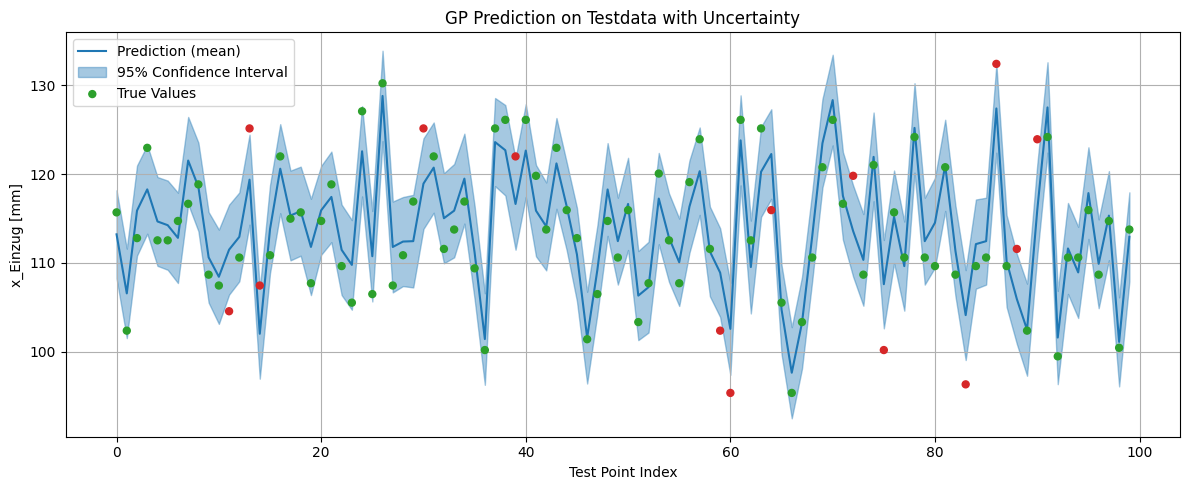

In [18]:
num_points = 100
np.random.seed(42)

random_indices = np.random.choice(len(X_test), num_points, replace=False)
random_indices.sort()

# Predictive distribution for train data (no gradients required)
with torch.no_grad():
    f_preds = model(X_train_tensor)            # Latent function predictions
    y_preds = likelihood(f_preds)        # Observed predictions with noise

# Extract mean and standard deviation from predictions
train_mean = y_preds.mean.cpu().numpy()

# Calculate R² for the train data
r2_test = r2_score(y_train, train_mean)
print(f"R² on Train Data: {r2_test:.3f}")


means = means.numpy()
stddevs = stddevs.numpy()
# Calculate R² for the test data
r2_test = r2_score(y_test, means)
print(f"R² on Test Data: {r2_test:.3f}")

# Define the confidence interval bounds (95% CI ≈ mean ± 2*std)
gp_lower = means - 2*stddevs
gp_upper = means + 2*stddevs

# Check whether each true value lies within the 95% confidence interval
# If yes, the point will be green; if not, red
in_interval = (y_test >= gp_lower) & (y_test <= gp_upper)

counter = 0
# Print whether each true value is within the confidence interval
for i in in_interval:
    if i:
        counter += 1

print(f"Number of true values within the confidence interval: {counter} out of {len(in_interval)}")

# Calculate coverage (percentage of true values within the CI)
coverage = np.mean(in_interval) * 100  # in percentage

# Print the coverage value
print(f"Coverage: {coverage:.2f}%")

# Check whether each true value from random indices lies within the 95% confidence interval
# If yes, the point will be green; if not, red
in_interval_rand_indi = (y_test[random_indices] >= gp_lower[random_indices]) & (y_test[random_indices] <= gp_upper[random_indices])
colors = ['tab:green' if inside else 'tab:red' for inside in in_interval_rand_indi]

# Plotting the prediction with uncertainty and true values
plt.figure(figsize=(12, 5))
x_axis = np.arange(num_points)

# Plot predicted mean
plt.plot(x_axis, means[random_indices], label="Prediction (mean)", color='tab:blue')

# Shade the 95% confidence interval (±2 standard deviations)
plt.fill_between(x_axis, gp_lower[random_indices], gp_upper[random_indices],
                 alpha=0.4, color='tab:blue', label='95% Confidence Interval')

# Plot true target values as orange dots
plt.scatter(x_axis, y_test[random_indices], label="True Values", c=colors, s=25, zorder=3)

# Add plot labels and formatting
plt.title("GP Prediction on Testdata with Uncertainty")
plt.xlabel("Test Point Index")
plt.ylabel("x_Einzug [mm]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()